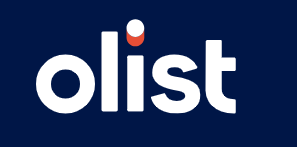

In [1]:
# check for PEP-8 compliance
# %load_ext pycodestyle_magic
# %pycodestyle_on
# %pycodestyle_off

In [1]:
# add notebook summary
import jyquickhelper as jqh
from jyquickhelper import add_notebook_menu
add_notebook_menu(menu_id='OCDS_P5', raw=False, format='html',
                  header="Olist Client Segmentation - Maintenance", first_level=1, last_level=5,
                  keep_item=None)

In [2]:
# check Python interpreter is running in 64-bit to maximize memory available for calculations
import struct
print(struct.calcsize("P") * 8)

64


In [3]:
# utilities
import os
os.environ["OMP_NUM_THREADS"] = '1' # needed to avoid memory leak warning with K-Means in Windows environment

# math & stats
import math

# data analysis
import numpy as np
import pandas as pd

# data visualisation
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
# from yellowbrick.cluster import KElbowVisualizer
# from yellowbrick.features import PCA

# metrics
from sklearn.metrics import adjusted_rand_score
from kneed import KneeLocator

# data preprocessing
from sklearn.preprocessing import scale, StandardScaler, PowerTransformer, OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from pyclustertend import vat

# configure transformers to output pandas DataFrames
# https://scikit-learn.org/1.5/auto_examples/miscellaneous/
# plot_set_output.html#sphx-glr-auto-examples-miscellaneous-plot-set-output-py
from sklearn import set_config
set_config(transform_output="pandas")

# avoid error message when running GridSearch with OneHotEncoder in Pipe
# Pandas output does not support sparse data. Set sparse_output=False to output pandas dataframes or disable Pandas output via
# ` ohe.set_output(transform="default")
# set_config(transform_output="default")

# PCA
from sklearn.decomposition import PCA

# clustering
import scipy.cluster.hierarchy as shc
from sklearn.cluster import KMeans, MiniBatchKMeans, DBSCAN, AffinityPropagation
from sklearn_extra.cluster import KMedoids
# from kmodes.kprototypes import KPrototypes
from sklearn.neighbors import NearestNeighbors
import hdbscan

# import user-defined functions
from functions import *

# set dataframe display options
pd.set_option('max_colwidth', None)
pd.set_option('display.max_columns', None)

# silence warnings after checking
import warnings
pd.set_option('future.no_silent_downcasting', False)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

# extract colors from logo for ppt slideshow
ciel = findColor('olist_blue.png')
cyan = findColor('olist_dark_blue.png')
cherry = findColor('olist_red.png')
print("ciel hex :", ciel)
print("cyan hex :", cyan)
print("cherry hex :", cherry)

ciel hex : #0a4ee4
cyan hex : #001647
cherry hex : #e64e36


In [4]:
# import data
data_trim = pd.read_csv('data_trim.csv', encoding='utf-8')
# data_trim.head(1)

In [5]:
data_trim['last_order_date'] = pd.to_datetime(data_trim['last_order_date'])

In [6]:
data_trim.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95340 entries, 0 to 95339
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   customer_id             95340 non-null  object        
 1   altitude                95340 non-null  float64       
 2   pop_density             95340 non-null  float64       
 3   motor_vehicles          95340 non-null  float64       
 4   GDP_per_capita          95340 non-null  float64       
 5   post_offices            95340 non-null  float64       
 6   tax_gdp_%               95340 non-null  float64       
 7   nb_of_orders            95340 non-null  float64       
 8   total_spent             95340 non-null  float64       
 9   total_freight           95340 non-null  float64       
 10  total_products          95340 non-null  float64       
 11  product_weight_avg      95340 non-null  float64       
 12  review_score_avg        95340 non-null  float6

In [7]:
# Define date range in file
data_start = data_trim['last_order_date'].min()
data_end = data_trim['last_order_date'].max()

# Calculate number of weeks in file
data_weeks = (data_end - data_start).days // 7
data_weeks

101

In [8]:
data_end

Timestamp('2018-08-29 00:00:00')

## 3.9 - Model drift & maintenance contract

**Calculate ARI scores with the following methodology :  
With the start date T0 equal to the date of the last transaction placed by a client in the file (29/08/2018), generate a customer file Fi at date Ti that includes all orders placed up until Ti, with Ti equal to T0 minus i weeks. 52 files will be generated, looking back a full year from the last transaction.
Initial model M0 is fitted at T0 on file F0 (which includes all of the transactions) and returns cluster numbers C0. At each date Ti, model M0 is used to predict the cluster numbers C0-i on each file Fi. A new model Mi is also fitted on each file Fi, and is used to predict cluster numbers Ci ; the ARI score is then calculated between cluster numbers C0-i and Ci on each file Fi.
The recommendation will be to re-train the model on new data as soon as the ARI score so obtained drops below 0.8 (commonly accepted threshold for accuracy in cluster numbers prediction).** 

- **Create weekly dataframes with client transactions, starting from data_end and looking back a year:**

In [9]:
def create_weekly_dfs(df, date_column, t0, nb_weeks_prior):
    """ Filter the DataFrame for orders up to end_date and return distinct DataFrames for each nb_weeks_prior """
    # Strip whitespace from column names
    df.columns = df.columns.str.strip()
    
    # Create dataframe to store week number and corresponding DataFrame names
    ari_df = pd.DataFrame(columns=['File Name', 'Week Number'])
    
    # Check if the specified date_column exists
    if date_column not in df.columns:
        raise KeyError(f"Column '{date_column}' not found in DataFrame. Available columns: {df.columns.tolist()}")

    # Create and store customer DataFrame at t0
    customer_df_t0 = df[df[date_column] <= t0].drop(columns=['customer_id', date_column], errors='ignore')
    
    # Store the results in a dictionary
    customer_dfs = {'t0': customer_df_t0}

    # Print size of the DataFrame at t0
    print(f"Size of the DataFrame at t0: {customer_df_t0.shape[0]} rows, {customer_df_t0.shape[1]} columns")

    for weeks_back in range(1, nb_weeks_prior + 1):  # From 1 week to nb_weeks_prior
        t1 = t0 + pd.Timedelta(weeks=-weeks_back)  # Calculate t1
        customer_df = df[df[date_column] <= t1].drop(columns=['customer_id', date_column], errors='ignore') # Filter df
        
        # Store the customer's DataFrame in the dictionary with a descriptive key
        customer_dfs[f'df_{weeks_back}_weeks_prior'] = customer_df
        
        # Create a new row for ARI dataframe
        new_row = pd.DataFrame({'DF Name': [f'df_{weeks_back}_weeks_prior'], 'Week Number': [weeks_back]})
        
        # Concatenate the new row with the existing ARI DataFrame
        ari_df = pd.concat([ari_df, new_row], ignore_index=True)
        
        # Print the size of the saved DataFrame
        print(f"Size of the DataFrame for {weeks_back} week(s) prior: {customer_df.shape[0]} rows,\
              {customer_df.shape[1]} columns")

    return customer_dfs, ari_df, customer_df_t0  # Return both created DataFrames and ARI DataFrame

In [10]:
initial_date = data_trim['last_order_date'].max()
# nb_weeks_prior = data_weeks  # Number of weeks to go back
nb_weeks_prior = 52

# Create customer files for each week prior
customer_dfs, ari_df, t0 = create_weekly_dfs(data_trim, 'last_order_date', initial_date, nb_weeks_prior)

Size of the DataFrame at t0: 95340 rows, 17 columns
Size of the DataFrame for 1 week(s) prior: 94848 rows,              17 columns
Size of the DataFrame for 2 week(s) prior: 93226 rows,              17 columns
Size of the DataFrame for 3 week(s) prior: 91460 rows,              17 columns
Size of the DataFrame for 4 week(s) prior: 89340 rows,              17 columns
Size of the DataFrame for 5 week(s) prior: 87678 rows,              17 columns
Size of the DataFrame for 6 week(s) prior: 85974 rows,              17 columns
Size of the DataFrame for 7 week(s) prior: 84658 rows,              17 columns
Size of the DataFrame for 8 week(s) prior: 83751 rows,              17 columns
Size of the DataFrame for 9 week(s) prior: 82413 rows,              17 columns
Size of the DataFrame for 10 week(s) prior: 80988 rows,              17 columns
Size of the DataFrame for 11 week(s) prior: 79604 rows,              17 columns
Size of the DataFrame for 12 week(s) prior: 78048 rows,              17 colum

- **Calculate ARI scores for cluster numbers C0-i obtained from model M0 fitted at T0 and predicted at Ti, and cluster numbers Ci obtained from model Mi fitted and predicted at Ti:**

In [11]:
def fit_and_predict_kmeans_4(data_at_t_zero, customer_dfs, n_clusters=4):
    """ Fit KMeans on data_at_t_zero, predict clusters for other DataFrames, and calculate ARI scores. """
    
    # Preprocess data_at_t_zero
    pt = PowerTransformer(method='yeo-johnson', standardize=True)
    X_transformed_t0 = pt.fit_transform(data_at_t_zero)

    # Fit KMeans on data_at_t_zero
    kmeans_t0 = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans_t0.fit(X_transformed_t0)
   
    # List to store ARI scores for DataFrame creation later
    ari_scores_list = []

    # Iterate through each customer DataFrame in the customer_dfs dictionary
    for index, (name, df) in enumerate(customer_dfs.items()):
        # Preprocess the other DataFrames using the same transformer
        X_transformed_other = pt.transform(df)
        
        # Predict clusters for the current DataFrame using the model fitted on data_at_t_zero
        t_zero_clusters = kmeans_t0.predict(X_transformed_other)

        # Fit KMeans on the current DataFrame
        kmeans_other = KMeans(n_clusters=n_clusters, random_state=42)
        kmeans_other.fit(X_transformed_other)

        # Predict clusters for the current DataFrame
        t_clusters = kmeans_other.predict(X_transformed_other)
        
        # Calculate ARI score between t_zero_clusters and t_clusters
        ari_score = adjusted_rand_score(t_zero_clusters, t_clusters)
        
        # Append ARI score to the list with index corresponding to DataFrame number
        ari_scores_list.append({'DF Name': name, 'Week Number': index, 'ARI Score': ari_score})
        
        # Print ARI score
        print(f"ARI score between t_zero_clusters and {name}: {ari_score:.4f}")

    # Convert ARI scores list to a DataFrame
    ari_scores_df = pd.DataFrame(ari_scores_list)

    return ari_scores_df

# Example usage:
# df = pd.read_csv('your_data.csv')  # Load your data here
# customer_dfs, ari_df = create_weekly_dfs(df, 'order_date', pd.Timestamp('2025-02-01'), 4)
# data_at_t_zero = customer_dfs['t0']  # Get the initial DataFrame for clustering
# output_dataframes, ari_scores = fit_and_predict_kmeans_4(data_at_t_zero, customer_dfs)


In [12]:
# Call the function to fit KMeans and calculate ARI scores
ari_scores = fit_and_predict_kmeans_4(t0, customer_dfs)

ARI score between t_zero_clusters and t0: 1.0000
ARI score between t_zero_clusters and df_1_weeks_prior: 0.9397
ARI score between t_zero_clusters and df_2_weeks_prior: 0.9446
ARI score between t_zero_clusters and df_3_weeks_prior: 0.9338
ARI score between t_zero_clusters and df_4_weeks_prior: 0.9672
ARI score between t_zero_clusters and df_5_weeks_prior: 0.9534
ARI score between t_zero_clusters and df_6_weeks_prior: 0.9200
ARI score between t_zero_clusters and df_7_weeks_prior: 0.9575
ARI score between t_zero_clusters and df_8_weeks_prior: 0.9523
ARI score between t_zero_clusters and df_9_weeks_prior: 0.9342
ARI score between t_zero_clusters and df_10_weeks_prior: 0.8989
ARI score between t_zero_clusters and df_11_weeks_prior: 0.9311
ARI score between t_zero_clusters and df_12_weeks_prior: 0.9352
ARI score between t_zero_clusters and df_13_weeks_prior: 0.8914
ARI score between t_zero_clusters and df_14_weeks_prior: 0.4303
ARI score between t_zero_clusters and df_15_weeks_prior: 0.3454


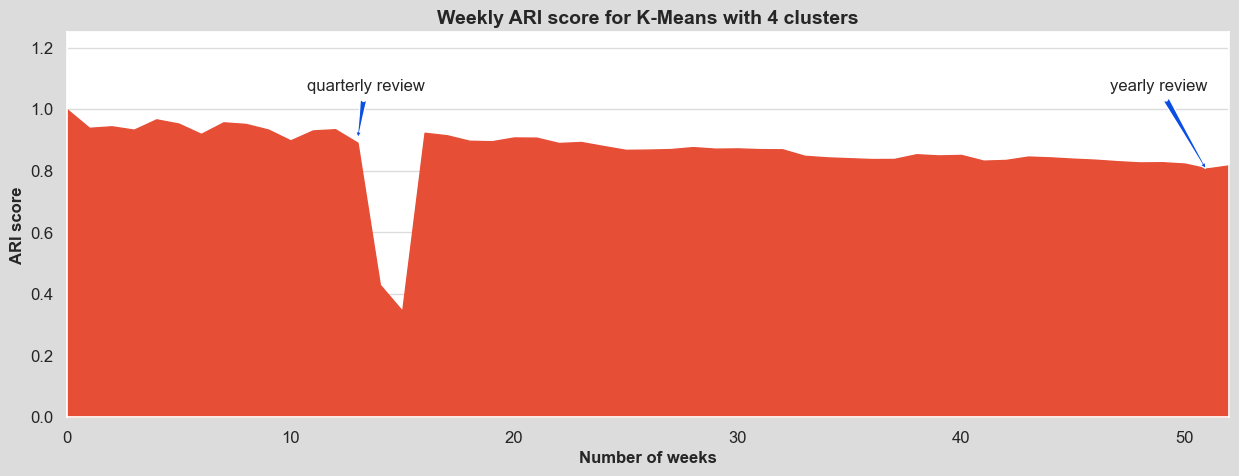

In [13]:
# plot ARI scores
sns.set(rc={'figure.figsize':(15, 5), 'axes.facecolor':'white', 'figure.facecolor':'gainsboro'})
x = ari_scores.index
y = ari_scores['ARI Score']
plt.fill_between(x, y, color=cherry)
plt.xlabel('Number of weeks', fontsize=12, fontweight='bold')
plt.xticks(fontsize=12)
plt.xlim(0, 52)
plt.ylim(0, 1.25)
plt.ylabel('ARI score', fontsize=12, fontweight='bold')
plt.yticks(fontsize=12)
plt.grid(axis='y', color='gainsboro')
plt.title('Weekly ARI score for K-Means with 4 clusters', fontsize=14, fontweight='bold')

# annotate graph
plt.annotate('quarterly review', xy=(13, 0.9), xycoords='data', xytext=(16, 1.1),
            textcoords='data', va='top', ha='right', arrowprops=dict(facecolor=ciel, arrowstyle='fancy'))

plt.annotate('yearly review', xy=(51, 0.8), xycoords='data', xytext=(51, 1.1),
            textcoords='data', va='top', ha='right', arrowprops=dict(facecolor=ciel, arrowstyle='fancy'))

plt.savefig('kmeans_maintenance.png')
plt.show()

**The ARI score drops below 0.8 after 13 weeks => re-fit model every 3 months. The ARI score then goes on to slowly decrease towards 0.8 after 51 weeks, so an additional annual review might be required.**